In [1]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder

In [3]:
df = pd.read_csv('../data/raw/AB_NYC_2019.csv')
df.set_index('id', inplace=True)
pd.set_option('display.max_columns', None)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 15)

In [5]:
unicos = df.nunique()
df[unicos[unicos==1].index]
print(unicos)

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64


In [6]:
df[unicos[unicos==1].index]


""
id
2539
2595
3647
3831
5022
...
36484665
36485057
36485431


In [7]:
#identificar filas duplicadas
df.duplicated().sum()

np.int64(0)

In [8]:
df.T.duplicated(keep=False)

name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [9]:
#Eliminar columnas redundantes
df.drop(['name','host_name'],axis=1,inplace=True) 


In [10]:
df.shape

(48895, 13)

In [11]:
#VALORES FALTANTES

faltantes = df.isna().mean()*100
faltantes[faltantes>0]

last_review          20.558339
reviews_per_month    20.558339
dtype: float64

In [12]:
df[df['reviews_per_month'].isna()==True]


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,
3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
7750,17985,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249
8700,26394,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0
11452,7355,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365
11943,45445,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36484665,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
36485057,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
36485431,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27


In [13]:
df.shape

(48895, 13)

In [14]:
n = 2
filas_con_n_faltantes = df[df.isnull().sum(axis=1) == n]
print(f"\nFilas con exactamente {n} valores faltantes:")
print(filas_con_n_faltantes)


Filas con exactamente 2 valores faltantes:
           host_id neighbourhood_group       neighbourhood  latitude  \
id                                                                     
3647          4632           Manhattan              Harlem  40.80902   
7750         17985           Manhattan         East Harlem  40.79685   
8700         26394           Manhattan              Inwood  40.86754   
11452         7355            Brooklyn  Bedford-Stuyvesant  40.68876   
11943        45445            Brooklyn            Flatbush  40.63702   
...            ...                 ...                 ...       ...   
36484665   8232441            Brooklyn  Bedford-Stuyvesant  40.67853   
36485057   6570630            Brooklyn            Bushwick  40.70184   
36485431  23492952           Manhattan              Harlem  40.81475   
36485609  30985759           Manhattan      Hell's Kitchen  40.75751   
36487245  68119814           Manhattan      Hell's Kitchen  40.76404   

          longitude

<Axes: >

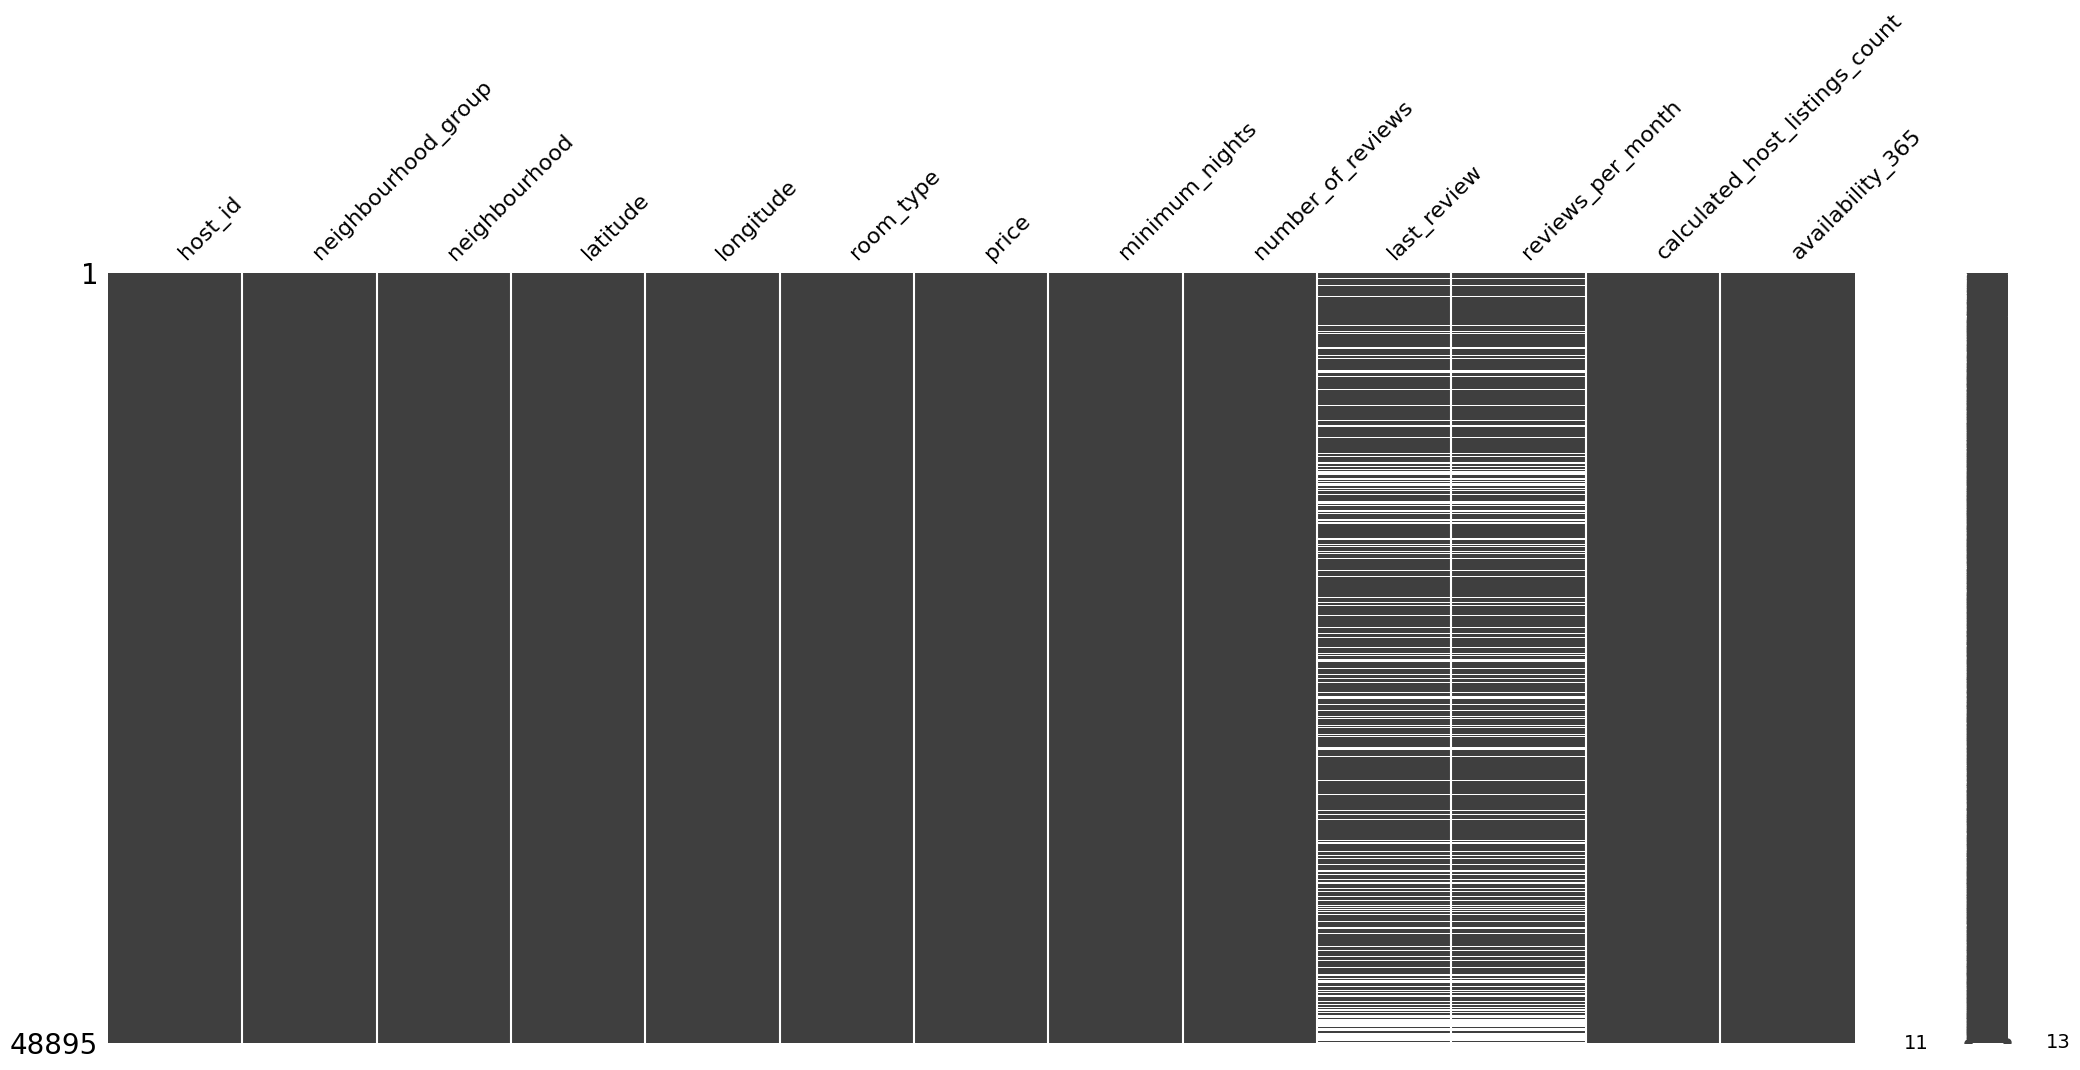

In [15]:
msno.matrix(df)

In [16]:
df['reviews_per_month'].fillna(0,inplace=True)
pd.set_option('display.max_columns', None)
df.head()

/tmp/ipykernel_7908/269757588.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0,inplace=True)


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [17]:
df['last_review'] = pd.to_datetime(df['last_review'])

cutoff_date = df['last_review'].max()

df['days_since_lastreview'] = (cutoff_date - df['last_review']).dt.days
pd.set_option('display.max_columns', None)
df.iloc()

In [18]:
#Imputar valor extremo a NaN "days since last review"
df['days_since_lastreview'].fillna(-1,inplace=True)
pd.set_option('display.max_columns',None)
df.head()

/tmp/ipykernel_7908/2856610966.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_since_lastreview'].fillna(-1,inplace=True)


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_since_lastreview
id,,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,262.0
2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,48.0
3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,0.00,1,365,-1.0
3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,3.0
5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,231.0


In [19]:
#Eliminar columna redundante "last_review"

df.drop(['last_review'],axis=1,inplace=True)
pd.set_option('display.max_columns',None)
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_lastreview
id,,,,,,,,,,,,,
2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,262.0
2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,48.0
3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,-1.0
3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,3.0
5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,231.0


In [20]:
X = df.drop('price',axis=1)
y = df['price']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
#SPLIT TRAIN/VALIDATION 

X_train1, X_val, y_train1, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=42
)

print(f"Train1: {X_train1.shape}")
print(f"Validation: {X_val.shape}")

Train1: (31292, 12)
Validation: (7824, 12)


In [23]:
counts = df['room_type'].value_counts()
print(counts)

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64


In [24]:
#Codificación de variables categóricas Ordinal encoder: para variable Room type

room_type_order = [['Shared room','Private room','Entire home/apt']]

ordinal_encoder = OrdinalEncoder(categories=room_type_order,handle_unknown='use_encoded_value',unknown_value=-1)

X_train['room_type_encoded'] = ordinal_encoder.fit_transform(X_train[['room_type']])
X_test['room_type_encoded']= ordinal_encoder.transform(X_test[['room_type']])

X_train.drop('room_type',axis=1,inplace=True)
X_test.drop('room_type',axis=1,inplace=True)

X_train.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_lastreview,room_type_encoded
id,,,,,,,,,,,,
25674366,9038810,Brooklyn,Williamsburg,40.71577,-73.95530,3,11,0.87,1,1,53.0,2.0
19100971,81745867,Manhattan,Washington Heights,40.84917,-73.94048,2,2,0.16,1,0,378.0,1.0
24209867,1218837,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,2,0,0.00,2,0,-1.0,1.0
22451798,4126686,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,3,87,4.91,1,267,3.0,2.0
5344850,27698133,Queens,Woodside,40.74705,-73.89564,5,13,0.25,1,0,202.0,1.0
